In [0]:
%load_ext autoreload
%autoreload 2

from agents import banditagents
from environments import bandits

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

In [6]:
bandit_config = {}
bandit_config['payoffs'] = [0.6, 0.3]
bandit_config['sampling_distribution'] = 'uniform'

demonstrator_config = {}
demonstrator_config['num_iterations'] = 2000
demonstrator_config['num_initial_rounds'] = 10
demonstrator_config['decay'] = None
demonstrator_config['epsilon'] = None
demonstrator_config['optimistic'] = None
demonstrator_config['solver'] = 'greedy'
demonstrator_config['random_agent'] = False
demonstrator_config['social_agent'] = False

learner_config = {}
learner_config['num_iterations'] = demonstrator_config['num_iterations']
learner_config['num_initial_rounds'] = demonstrator_config['num_initial_rounds']
learner_config['decay'] = demonstrator_config['decay']
learner_config['epsilon'] = demonstrator_config['epsilon']
learner_config['optimistic'] = demonstrator_config['optimistic']
learner_config['solver'] = demonstrator_config['solver'] 
learner_config['random_agent'] = demonstrator_config['random_agent']
learner_config['social_agent'] = True
learner_config['observe_simultaneously'] = True
learner_config['observe_action_only'] = True
learner_config['observe_current_iteration'] = True

num_episodes = 50
solvers = ['greedy']

demonstrator_all_rewards = np.empty(shape=(len(solvers),num_episodes, demonstrator_config['num_iterations']),dtype=float)
demonstrator_all_actions = np.empty(shape=(len(solvers),num_episodes, demonstrator_config['num_iterations']),dtype=float)

learner_all_rewards = np.empty(shape=(len(solvers),num_episodes, learner_config['num_iterations']),dtype=float)
learner_all_actions = np.empty(shape=(len(solvers),num_episodes, learner_config['num_iterations']),dtype=float)

env = bandits.Bandit(bandit_config)
for i, solver in enumerate(solvers):
    for j in range(num_episodes):
        demonstrator = banditagents.GreedyAgent(demonstrator_config)
        # run greedy explore
        demonstrator(env)
        demonstrator_all_rewards[i,j,:] = demonstrator.reward_history
        demonstrator_all_actions[i,j,:] = demonstrator.arm_id_history


        learner = banditagents.GreedyAgent(learner_config)
        # run greedy explore
        learner(env, demonstrator)
        learner_all_rewards[i,j,:] = learner.reward_history
        learner_all_actions[i,j,:] = learner.arm_id_history



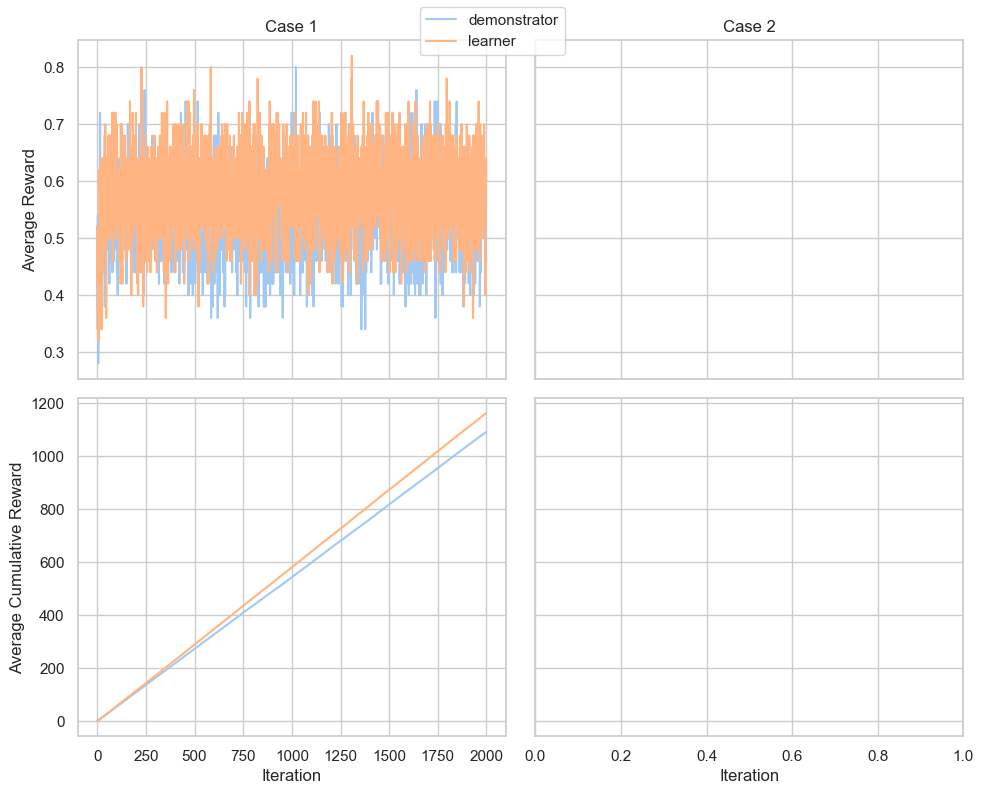

In [11]:
demonstrator_mean_reward_per_iteration = np.mean(demonstrator_all_rewards, axis=1)
demonstrator_sd_reward_per_iteration = np.mean(demonstrator_all_rewards, axis=1)
demonstrator_mean_cumulative_reward = np.cumsum(demonstrator_mean_reward_per_iteration,axis=1)

learner_mean_reward_per_iteration = np.mean(learner_all_rewards, axis=1)
learner_sd_reward_per_iteration = np.mean(learner_all_rewards, axis=1)
learner_mean_cumulative_reward = np.cumsum(learner_mean_reward_per_iteration,axis=1)

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10,8), sharex='col', sharey='row')

for i, agent_type in enumerate(solvers):
    axes[0,0].plot(demonstrator_mean_reward_per_iteration[i], label=agent_type)
    axes[1,0].plot(demonstrator_mean_cumulative_reward[i], label='demonstrator')

    axes[0,0].plot(learner_mean_reward_per_iteration[i], label=agent_type)
    axes[1,0].plot(learner_mean_cumulative_reward[i], label='learner')
    

axes[1,0].set_ylabel('Average Cumulative Reward')
axes[0,0].set_ylabel('Average Reward')
axes[1,0].set_xlabel('Iteration')
axes[1,1].set_xlabel('Iteration')
axes[0,0].set_title('Case 1')
axes[0,1].set_title('Case 2')
handles, labels = axes[1,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.tight_layout()
plt.show()

# try different learners
1. observe simultaneously
2. observe as choice 
3. observe action only 
4. observe action and reward
5. change arm probabilities
6. what to observe - best action or current action


# try two agents learning together
